# GPs. Notebook 1. Introduction to Gaussian Processes

------------------------------------------------------
*Machine Learning, Master in Information & Health Engineering

*Pablo M. Olmos olmos@tsc.uc3m.es*

------------------------------------------------------

Gaussian processes have emerged as one of the most powerful techniques to perform probabilistic tasks such as regression, classification and both linear/non-linear dimensionality reduction. They are a must in  in **high-dimensional problems** with small datasets. In the past few years, scalable versions have been developed, allowing the use of [GPs with millions of training points](https://arxiv.org/pdf/1610.05392.pdf), achieving competitive results with respect to deep learning approaches. 

Recommended Bibliography:

- [An introduction to Gaussian Processes](http://www.inference.org.uk/mackay/gpB.pdf), by David J.C. Mackay
- Chapter 6 of [Bayesian Reasoning and Machine Learning](http://web4.cs.ucl.ac.uk/staff/D.Barber/textbook/090310.pdf), David Barber, 2010
- Chapter 15 of Machine Learning: a probabilistic perspective, Kevin Murphy 2012
- [Gaussian Processes for Machine Learning](Gaussian Processes for Machine Learning), by Carl Edward Rasmussen and Christopher K. I. Williams. 

And these slides are really nice

-[A Tutorial on Gaussian Processes (or why I don’t use SVMs)](http://mlss2011.comp.nus.edu.sg/uploads/Site/lect1gp.pdf), by Zoubin Ghahramani



**The following examples are mainly based on the tutorials included in the GPy official documentation**. I added some more details and interpretations, but everything is based on their exellent work!

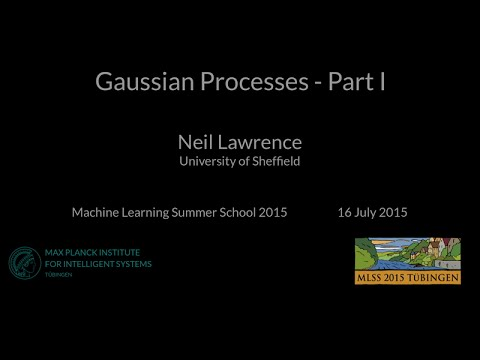

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo('S9RbSCpy_pg')   # Gaussian Processes Part I by Neil Lawence at the 2015 Machine Learning Summer School

#YouTubeVideo('MxeQIKGEXb8')   # Part II

#YouTubeVideo('MxeQIKGEXb8')   # Part III
 

## Installing and importing GPy Library

[GPy](https://sheffieldml.github.io/GPy/) is a Gaussian Process (GP) framework written in python, from the Sheffield machine learning group. 

We asume GPy is already installed in your computer. If is not, follow the instructions provided in their [Github repository](https://github.com/SheffieldML/GPy). 


In [2]:
# You can also install GPy using the following command (Works on Windows!)

!pip install GPy 

In [3]:
import GPy
import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'   ##QUALITY FIGURES!!
plt.rcParams["figure.figsize"] = [8,8]

## 1-dimensional regression example

We will now combine the Gaussian process prior with some data to form a GP regression model with GPy. We will generate data from the function $f ( x ) = − \cos(2*\pi x ) + \sin(4\pi x )$ over $[0, 1]$, adding some noise to give $y(x) = f(x) + \epsilon$, with the noise being Gaussian distributed, $\epsilon \sim \mathcal{N}(0, 0.01)$. 

(-1, 1)

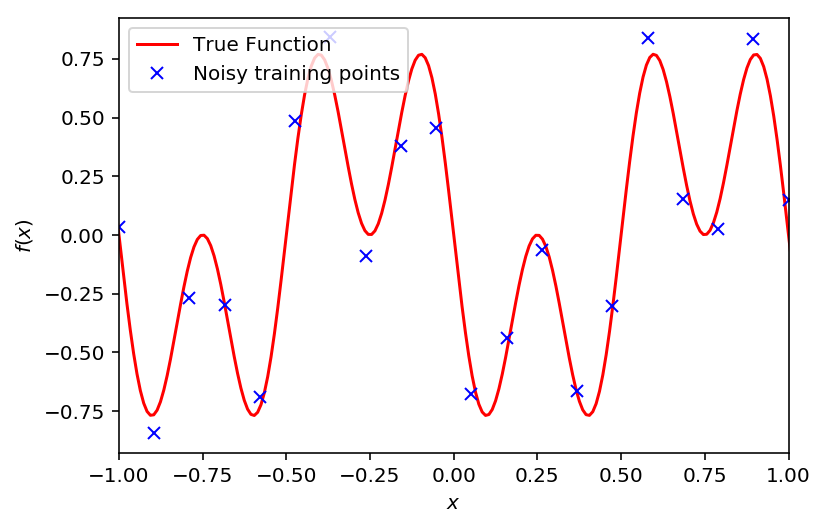

In [4]:
npoints = 20
X = np.linspace(-1,1,npoints)[:,None]
Y = -np.cos(2*np.pi*X)* + np.sin(4*np.pi*X) + np.random.randn(npoints,1) * np.sqrt(0.01)

X_true = np.linspace(-5,5,1000)[:,None]
Y_true = -np.cos(2*np.pi*X_true)* + np.sin(4*np.pi*X_true)

plt.figure()
plt.plot(X_true,Y_true,'r')
plt.plot(X,Y,'bx',ms=6)
plt.legend(['True Function','Noisy training points'])
plt.xlabel('$x$')
plt.ylabel('$f(x)$')
plt.xlim([-1,1])

The first step is to define the covariance kernel we want to use for the model. We choose here a kernel based on Gaussian kernel (i.e. rbf or square exponential):

\begin{align}
k(\mathbf{x},\mathbf{x}^*) = \sigma^2 \exp \left(- \frac{||\mathbf{x}-\mathbf{x}^*||^2}{2 \ell^2}\right),
\end{align}
where $\sigma^2$ and $\ell^2$ are the variance and the lengthscale hyperparameters. These parameters are optional (we will learn them later by maximizing the model evidence), and their default value is 1.

In [5]:
kernel = GPy.kern.RBF(input_dim=1, variance=1., lengthscale=1)

The inputs required for building the model are the observations and the kernel:

In [6]:
m = GPy.models.GPRegression(X,Y,kernel)

By default, some observation noise is added to the model (with variance equal to 1). The functions display and plot give an insight of the model we have just built:

In [7]:
from IPython.display import display
display(m)
#You can also type print(m), but is not that nicely formatted

GP_regression.,value,constraints,priors
rbf.variance,1.0,+ve,
rbf.lengthscale,1.0,+ve,
Gaussian_noise.variance,1.0,+ve,


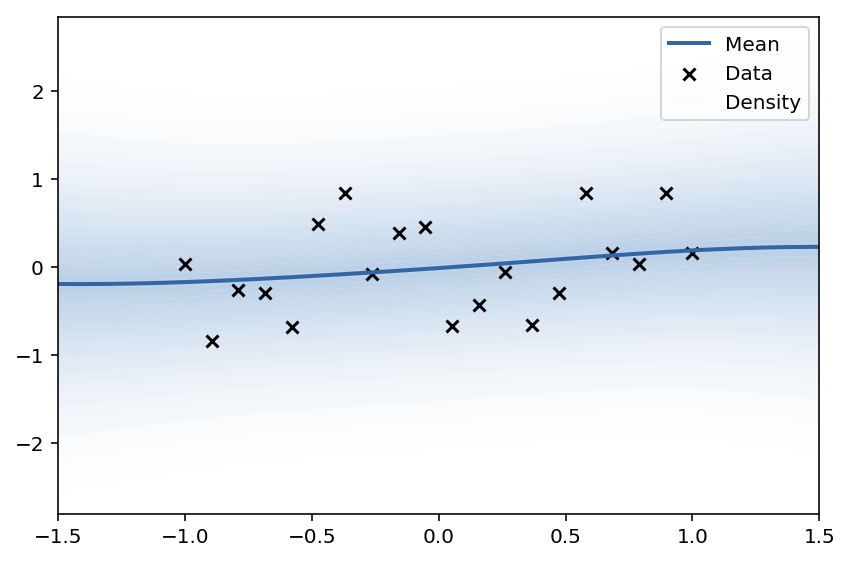

In [8]:
fig = m.plot(plot_density=True)

The above cell shows our GP regression model **before optimization of the parameters**. The shaded region corresponds to ~95% confidence intervals (ie +/- 2 standard deviation).

The default values of the kernel parameters may not be optimal for the current data (for example, the confidence intervals seems too wide on the previous figure). A common approach is to find the values of the parameters that maximize the likelihood (also called evidence) of the data. It as easy as calling m.optimize in GPy:


In [9]:
m.optimize(messages=True)

If we want to perform some restarts to try to improve the result of the optimization, we can use the optimize_restarts function. This selects random (drawn from $\mathcal{N}(0,1)$) initializations for the parameter values, optimizes each, and sets the model to the best solution found.

In [10]:
m.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 15.076392240993103
Optimization restart 2/10, f = 15.076406302407493
Optimization restart 3/10, f = 14.503679799708834
Optimization restart 4/10, f = 15.07640199529697
Optimization restart 5/10, f = 14.861201258739532
Optimization restart 6/10, f = 14.861201258076143
Optimization restart 7/10, f = 14.861201258073116
Optimization restart 8/10, f = 14.503679571659454
Optimization restart 9/10, f = 14.861201258072942
Optimization restart 10/10, f = 15.076395632372057


Let's plot the trained model

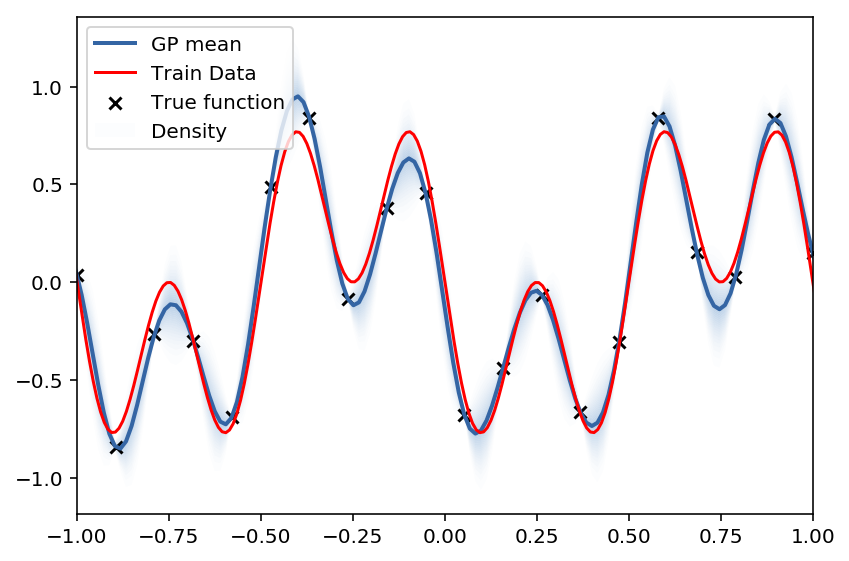

In [11]:
fig = m.plot(plot_density=True)

plt.plot(X_true,Y_true,'r')
plt.xlim([-1,1])
plt.legend(['GP mean','Train Data','True function','Density'])

## The periodic exponential kernel

Let's visualize GP samples for values $X\in[-5,5]$. Also, the estimated mean.

In [12]:
#Test set
#Xtest = np.linspace(-5,5,200)[:,None]
#Ytest = -np.cos(2*np.pi*Xtest) + np.sin(4*np.pi*Xtest) + np.random.randn(200,1) * np.sqrt(0.01)

nsamples = 20
posteriorYtest = m.posterior_samples_f(X_true, full_cov=True, size=nsamples)
meanYtest,_ = m.predict(X_true,full_cov=True)


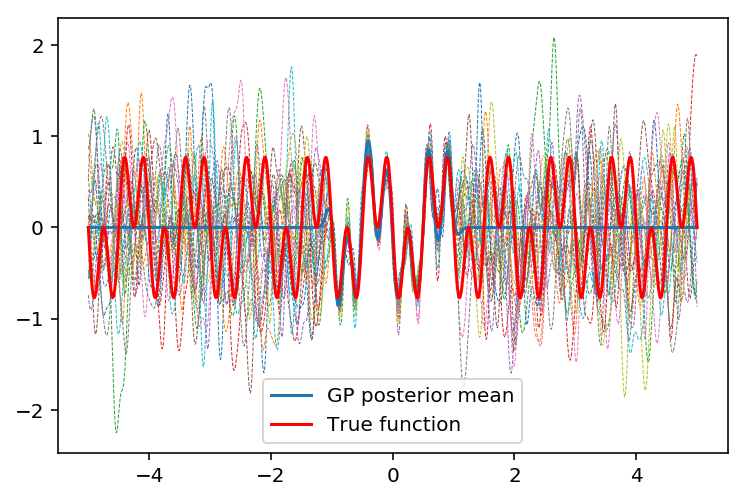

In [13]:
plt.figure()

plt.plot(X_true,posteriorYtest.reshape([-1,nsamples]),'--',lw=0.5,)
plt.plot(X_true,meanYtest,label='GP posterior mean')
plt.plot(X_true,Y_true,'r',label='True function')
plt.legend()

Obviously, since the GP has never seen data points out of the $[-1,1]$ range, then its uncertainty out of this region grows very fast and its estimation is esentially a zero-mean output.

**What if we knew that the signal we try to fit is periodic?**

If so, we should incorporate this information to the kernel itself!! 

Fortunately, GPy incorporates [a periodic exponential kernel](http://gpy.readthedocs.io/en/deploy/GPy.kern.src.html#module-GPy.kern.src.periodic)


In [14]:
kernel2 = GPy.kern.PeriodicExponential(input_dim=1,variance=1.,lengthscale=1.) #The default period is 2*pi

In [15]:
m2 = GPy.models.GPRegression(X,Y,kernel2)

In [16]:
X.shape

(20, 1)

In [17]:
display(m2)

GP_regression.,value,constraints,priors
periodic_exponential.variance,1.0,+ve,
periodic_exponential.lengthscale,1.0,+ve,
periodic_exponential.period,6.283185307179586,+ve,
Gaussian_noise.variance,1.0,+ve,


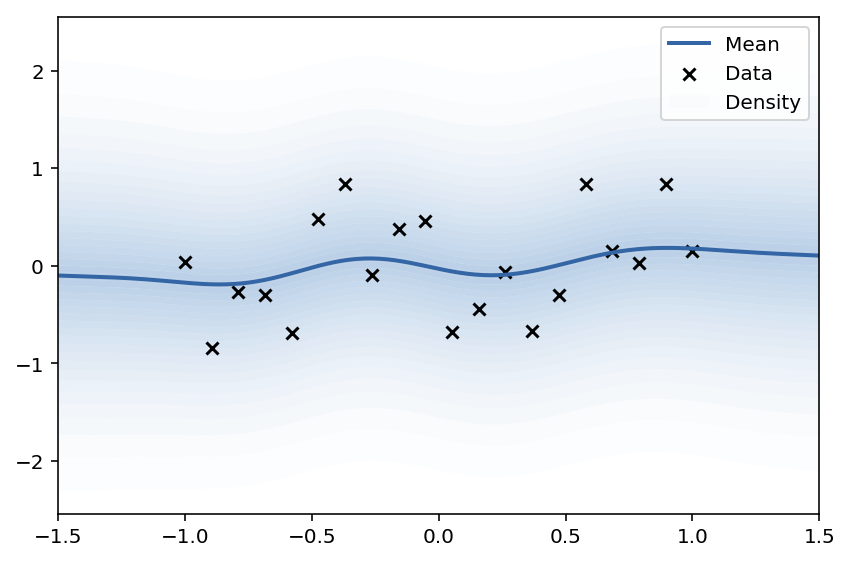

In [18]:
fig = m2.plot(plot_density=True)

Let's train the GP with the periodic kernel. **Recall that all of our training points are still in the [-1,1] region**

In [19]:
m2.optimize_restarts(num_restarts = 10)

Optimization restart 1/10, f = 5.841930768392281
Optimization restart 2/10, f = 14.57209369464314
Optimization restart 3/10, f = 3.090786934939734
Optimization restart 4/10, f = 15.076393241848491
Optimization restart 5/10, f = 12.041541524734873
Optimization restart 6/10, f = 11.602798252869825
Optimization restart 7/10, f = 9.012981683593834
Optimization restart 8/10, f = 7.74487818787404
Optimization restart 9/10, f = 3.0907869323005066
Optimization restart 10/10, f = 3.090786938075773


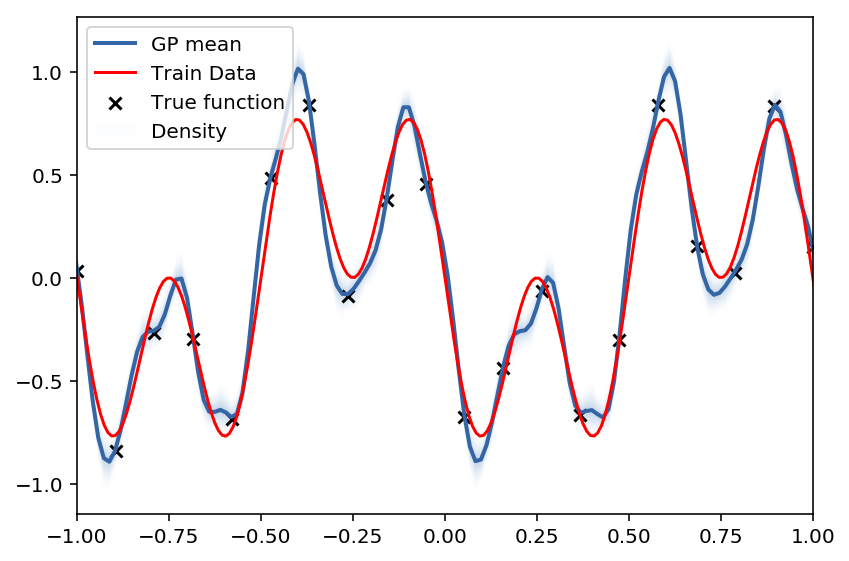

In [20]:
fig = m2.plot(plot_density=True)

plt.plot(X_true,Y_true,'r')
plt.xlim([-1,1])
plt.legend(['GP mean','Train Data','True function','Density'])

In [21]:
display(m2) # Observe that the period is nicely found

GP_regression.,value,constraints,priors
periodic_exponential.variance,8.528002708044522,+ve,
periodic_exponential.lengthscale,0.3402530966043189,+ve,
periodic_exponential.period,1.0049539835308812,+ve,
Gaussian_noise.variance,0.0010669203574865957,+ve,


If we now plot samples of the posterior GP, we inmmediatly realize that, by exploiting the periodicity of the unobserved signal, it is able to generalize to regions where it did never see any training points.

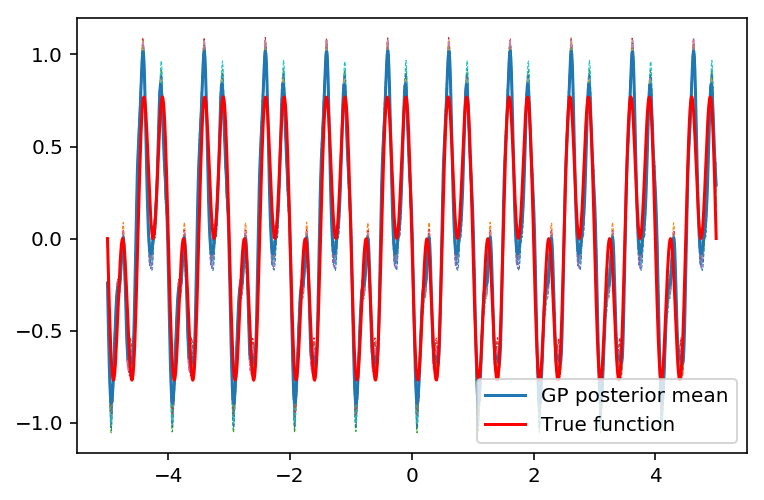

In [22]:
posteriorYtest2 = m2.posterior_samples_f(X_true, full_cov=True, size=nsamples)
meanYtest2,_ = m2.predict(X_true,full_cov=True)

plt.figure()

plt.plot(X_true,posteriorYtest2.reshape([-1,nsamples]),'--',lw=0.5,)
plt.plot(X_true,meanYtest2,label='GP posterior mean')
plt.plot(X_true,Y_true,'r',label='True function')
plt.legend()

### On kernels and combinations of kernels

It is a **must** to [**check out this tutorial**](http://nbviewer.jupyter.org/github/SheffieldML/notebook/blob/master/GPy/basic_kernels.ipynb) to see a list of implemented kernels and allowed combinations to generate new ones!

## Regression with 2D inputs

Let's load another database, this time with multidimensional inputs. 

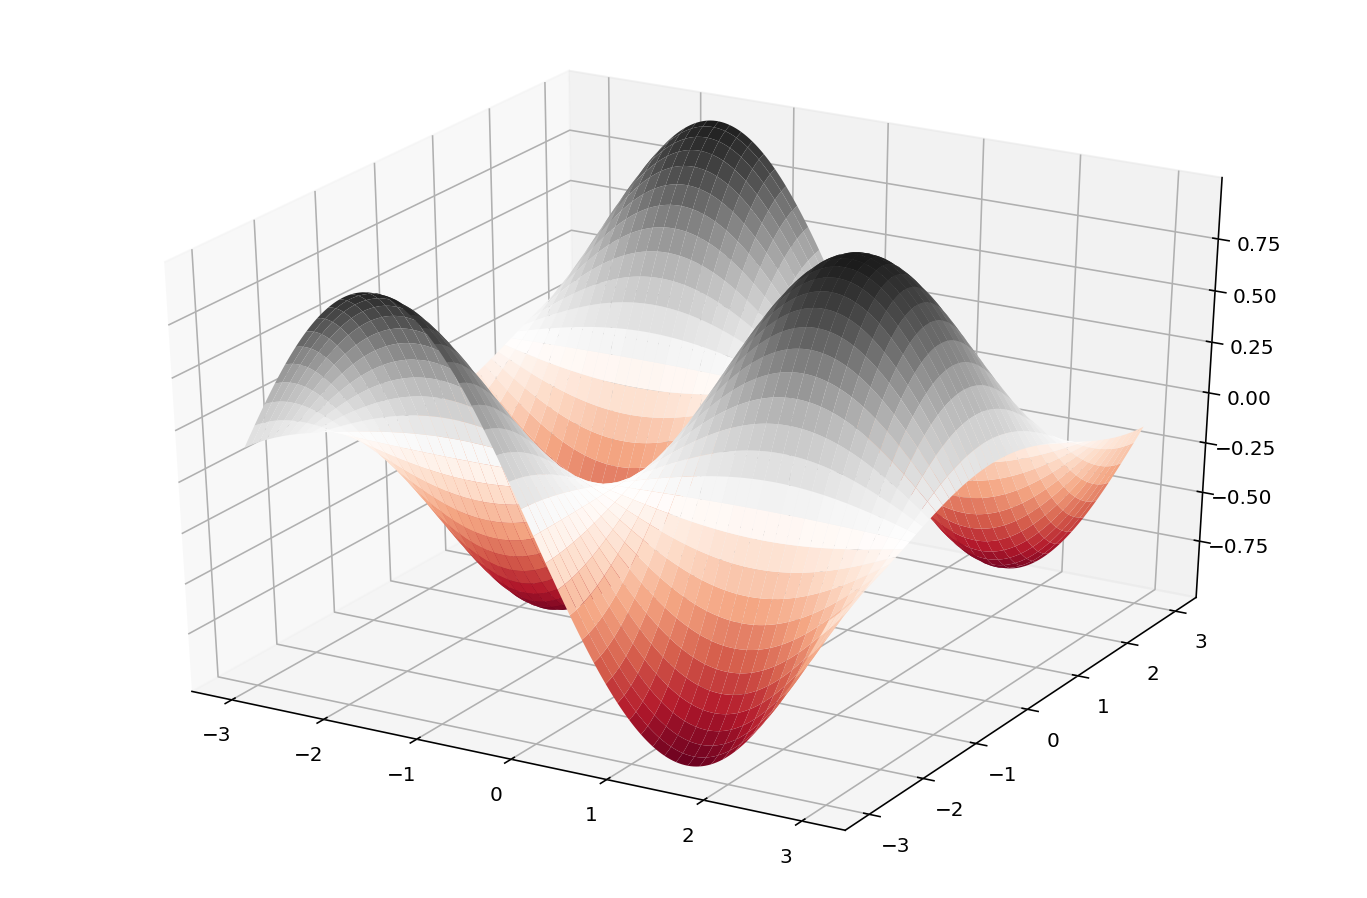

In [23]:
# True surface
intervals = 200
a = np.linspace(-3, 3, intervals)
b = np.linspace(-3, 3, intervals)

C,D = np.meshgrid(a,b)

cyd = np.vstack([C.ravel(), D.ravel()]).T

Z = np.sin(cyd[:,0])* np.cos(cyd[:,1])

Z = Z.reshape([intervals,intervals])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(C, D, Z, cmap='RdGy')

{'dataplot': [<matplotlib.collections.PathCollection at 0x1a159a7358>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1a159a72b0>]}

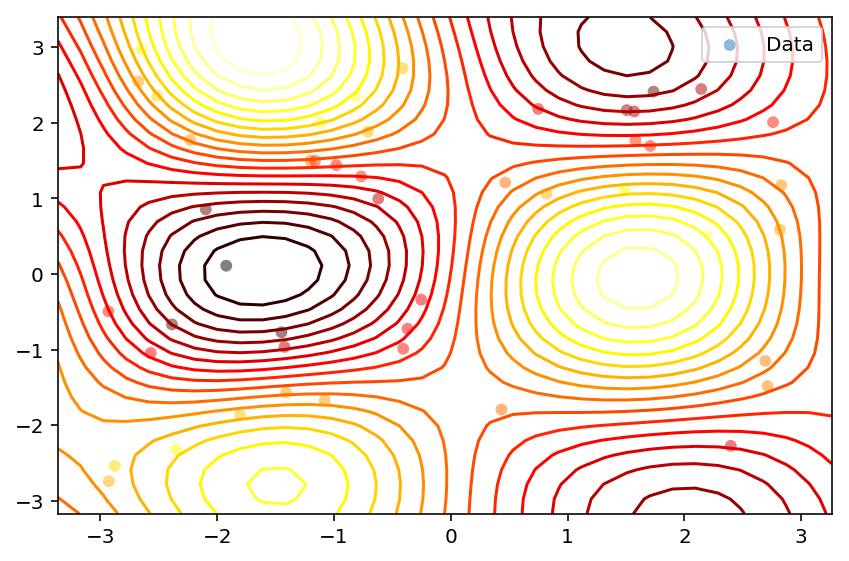

In [24]:
# sample noisy training points
npoints = 50
X = np.random.uniform(-3.,3.,(npoints,2))
Y = np.sin(X[:,0]) * np.cos(X[:,1])+np.random.randn(npoints,)*np.sqrt(0.01)

# define kernel
ker3 = GPy.kern.RBF(2,ARD=True) + GPy.kern.White(2)

# create simple GP model
m3 = GPy.models.GPRegression(X,Y.reshape([-1,1]),ker3)

# optimize and plot
m3.optimize(messages=True,max_f_eval = 1000)
m3.plot()



Observe we have used an  **Automatic Relevance Determination** kernel **plus a white noise kernel**. In the RBF-ARD kernel,  each input dimension has a different lengthscale, hence enabling interpretability:

\begin{align}
k(\mathbf{x},\mathbf{x}^*) = \sigma^2 \exp \left(- \sum_{d=1}^{D} \frac{(x_d-x_d^*)^2}{2\ell_d^2}\right) + \gamma
\end{align}

Let's get a list of all kernel hyperparameters and their values

In [25]:
print(ker3.parameter_names())

print(ker3.rbf.variance.values)

print(ker3.rbf.lengthscale.values)

print(ker3.white.variance.values)

['rbf.variance', 'rbf.lengthscale', 'white.variance']
[0.38437103]
[1.23290908 1.45579177]
[0.00255059]


In this example, both dimensions weight equally in the GP kernel. Lets create another example where this does not happen.

## Regression with 2D inputs (example 2)

Observe that $Y$ points are not really correlated through $X[:,1]$. This should be captured by the ARD parameter in the GP kernel!

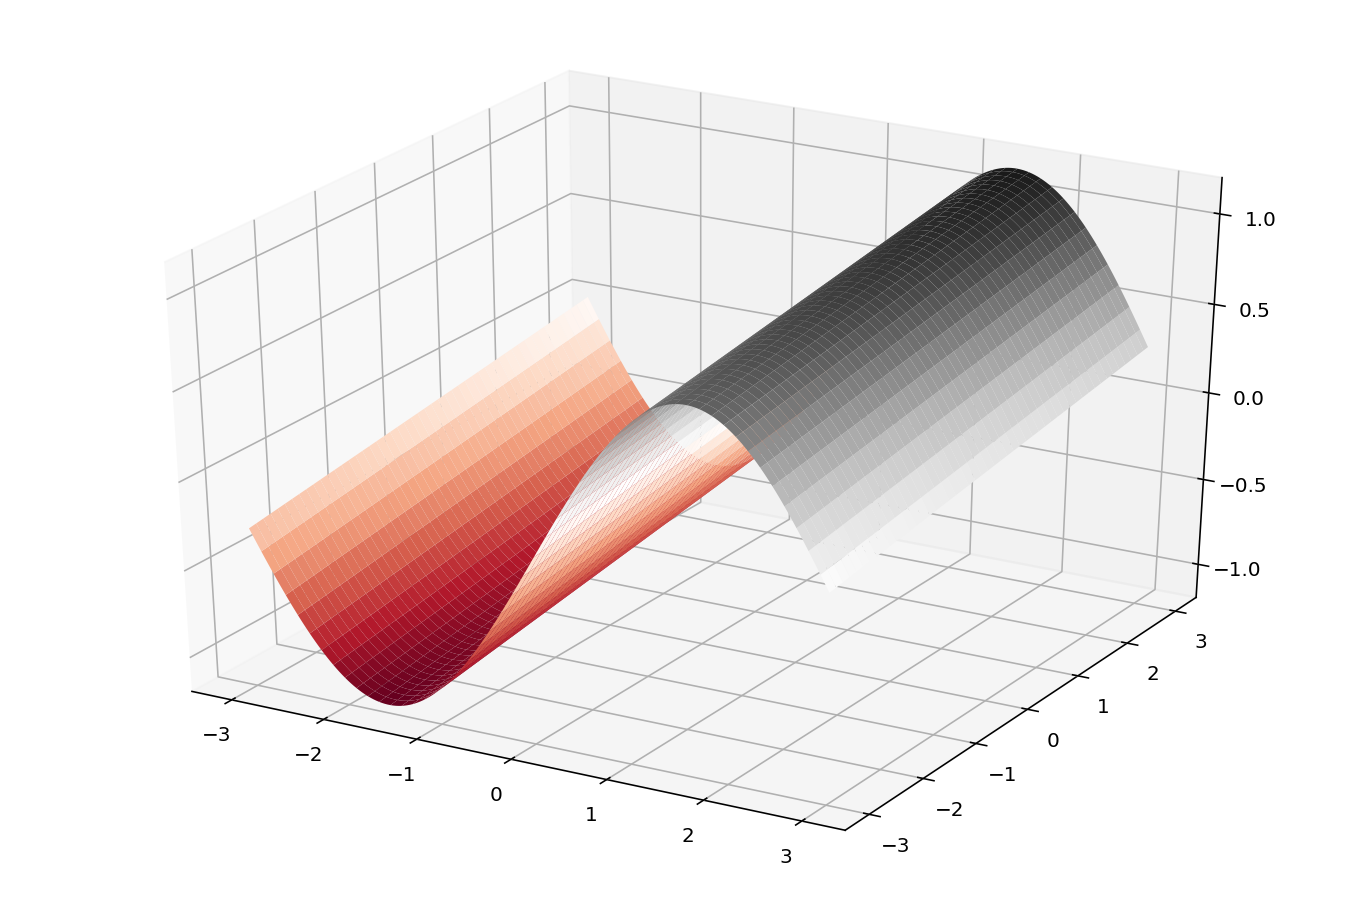

In [26]:
# True surface
intervals = 200
a = np.linspace(-3, 3, intervals)
b = np.linspace(-3, 3, intervals)

C,D = np.meshgrid(a,b)

cyd = np.vstack([C.ravel(), D.ravel()]).T

Z = np.sin(cyd[:,0])+ 0.05*(cyd[:,1])

Z = Z.reshape([intervals,intervals])

fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(C, D, Z, cmap='RdGy')

In [27]:
# sample noisy training points
npoints = 50
X = np.random.uniform(-3.,3.,(npoints,2))
Y = np.sin(X[:,0:1]) + 0.05*X[:,1:2]+np.random.randn(npoints,1)*np.sqrt(0.01)



{'dataplot': [<matplotlib.collections.PathCollection at 0x1a162bc1d0>],
 'gpmean': [<matplotlib.contour.QuadContourSet at 0x1a162bc128>]}

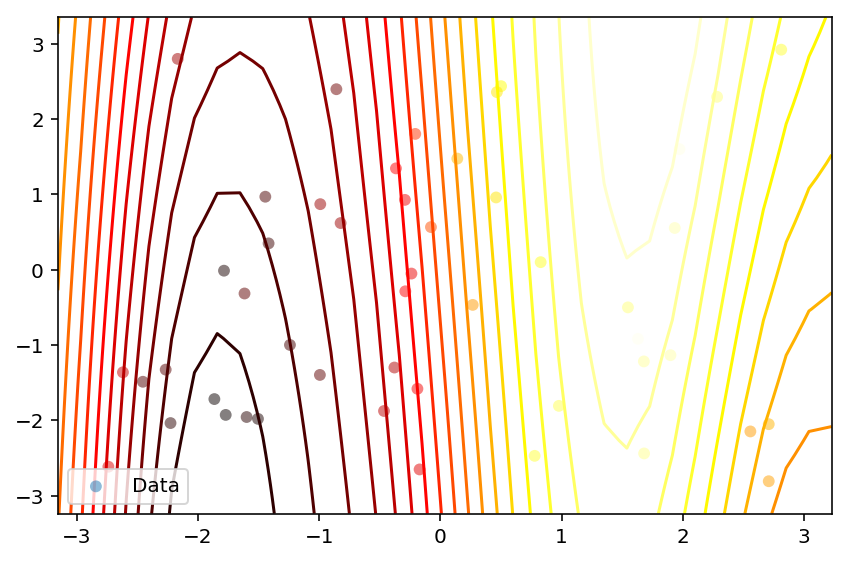

In [28]:
# define kernel
ker4 = GPy.kern.RBF(2,ARD=True) + GPy.kern.White(2)

# create simple GP model
m4 = GPy.models.GPRegression(X,Y,ker4)

# optimize and plot
m4.optimize(messages=True,max_f_eval = 1000)
m4.plot()


In [29]:
print(ker4.parameter_names())

print(ker4.rbf.variance.values)

print(ker4.rbf.lengthscale.values)

print(ker4.white.variance.values)

['rbf.variance', 'rbf.lengthscale', 'white.variance']
[0.43467312]
[ 0.9343655  12.57127748]
[0.00327359]


Note that the lengthscale corresponding to the second dimension is much larger!! 